In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from efficientnet_pytorch import EfficientNet

md_ef =  EfficientNet.from_pretrained('efficientnet-b4', num_classes=1) 


Loaded pretrained weights for efficientnet-b4


In [2]:
FOLD = 2
EXP_NAME = f'NB_EXP_765_CV_{FOLD}'
PATH = Path('../')
OLD_TRAIN = PATH/'old_train.csv'
OLD_TEST  = PATH/'old_test.csv'
TRAIN     = PATH/'train.csv'
IMG_OLD_TRAIN_224 = PATH/'old_train_images_224_crop'
IMG_OLD_TEST_224  = PATH/'old_test_images_224_crop'
IMG_TRAIN_224     = PATH/'train_images_224_crop'
BS = 128
SZ = 224

In [3]:

import math
import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it
#from torch.optim import Optimizer
#credit - Lookahead implementation from LonePatient - https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
#credit2 - RAdam code by https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam.py


class Ranger(Optimizer):
    
    def __init__(self, params, lr=1e-3, alpha=0.5, k=6, betas=(.9,0.999), eps=1e-8, weight_decay=0):
        #parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')
        
        #prep defaults and init torch.optim base
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params,defaults)
        
        #now we can get to work...
        for group in self.param_groups:
            group["step_counter"] = 0
            #print("group step counter init")
                      
        #look ahead params
        self.alpha = alpha
        self.k = k 
        
        #radam buffer for state
        self.radam_buffer = [[None,None,None] for ind in range(10)]
        
        #lookahead weights
        self.slow_weights = [[p.clone().detach() for p in group['params']]
                                for group in self.param_groups]
        
        #don't use grad for lookahead weights
        for w in it.chain(*self.slow_weights):
            w.requires_grad = False
        
    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)
       
        
    def step(self, closure=None):
        loss = None
        #note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.  
        #Uncomment if you need to use the actual closure...
        
        #if closure is not None:
            #loss = closure()
            
        #------------ radam
        for group in self.param_groups:
    
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')
    
                p_data_fp32 = p.data.float()
    
                state = self.state[p]
    
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)
    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
    
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
    
                state['step'] += 1
                buffered = self.radam_buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size
    
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
    
                if N_sma > 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)
    
                p.data.copy_(p_data_fp32)
        
        
        #---------------- end radam step
        
        #look ahead tracking and updating if latest batch = k
        for group,slow_weights in zip(self.param_groups,self.slow_weights):
            group['step_counter'] += 1
            if group['step_counter'] % self.k != 0:
                continue
            for p,q in zip(group['params'],slow_weights):
                if p.grad is None:
                    continue
                q.data.add_(self.alpha,p.data - q.data)
                p.data.copy_(q.data)
            
        
            
        return loss

In [4]:
def apply_path(path, exten, df, col_name='image'):
    df[col_name] = df[col_name].apply(lambda x: f'{str(path)}/{x}{exten}')
    return df


def get_ign_list(df):
    ignore_list = ['2b21d293fdf2.png','4d7d6928534a.png','a505981d1cab.png','2923971566fe.png','05a5183c92d0.png','30cab14951ac.png','6b00cb764237.png','35aa7f5c2ec0.png','03676c71ed1b.png','7550966ef777.png','0c7e82daf5a0.png','2cceb07ff706.png','1c9c583c10bf.png','026dcd9af143.png','fe0fc67c7980.png','0ac436400db4.png','14515b8f19b6.png','3cd801ffdbf0.png','3dbfbc11e105.png','1cb814ed6332.png','012a242ac6ff.png','b187b3c93afb.png','034cb07a550f.png','a9e984b57556.png','b9127e38d9b9.png','4ce74e5eb51d.png','278aa860dffd.png','1b4625877527.png','bb7e0a2544cd.png','01c31b10ab99.png','4fecf87184e6.png','d28bd830c171.png','530d78467615.png','bcdc8db5423b.png','51131b48f9d4.png','6165081b9021.png','bacfb1029f6b.png','5e7db41b3bee.png','aeed1f251ceb.png','fda39982a810.png','1dfbede13143.png','80feb1f7ca5e.png','a8b637abd96b.png','5eb311bcb5f9.png','e12d41e7b221.png','4a44cc840ebe.png','e4e343eaae2a.png','ce887b196c23.png','23d7ca170bdb.png','b8ac328009e0.png','9c5dd3612f0c.png','f23902998c21.png','1ae8c165fd53.png','9f1efb799b7b.png','68332fdcaa70.png','aca88f566228.png','144b01e7b993.png','7e160c8b611e.png','14e3f84445f7.png','e39b627cf648.png','1c5e6cdc7ee1.png','ca0f1a17c8e5.png','8cb6b0efaaac.png','80964d8e0863.png','1632c4311fc9.png','9a3c03a5ad0f.png','7005be54cab1.png','5b76117c4bcb.png','f066db7a2efe.png','840527bc6628.png','b06dabab4f09.png','48c49f662f7d.png','d51b3fe0fa1b.png','9b7b6e4db1d5.png','9b32e8ef0ca0.png','04ac765f91a1.png','40e9b5630438.png','1ee1eb7943db.png','9b418ce42c13.png','e4151feb8443.png','1006345f70b7.png','7a0cff4c24b2.png','0161338f53cc.png','fcc6aa6755e6.png','8446826853d0.png','1c4d87baaffc.png','e740af6ac6ea.png','3a1d3ce00f0c.png','0cb14014117d.png','11242a67122d.png','36041171f441.png','1c6d119c3d70.png','75a7bc945b7d.png','3f44d749cd0b.png','ca891d37a43c.png','f03d3c4ce7fb.png','a1b12fdce6c3.png','025a169a0bb0.png','9e3510963315.png','36677b70b1ef.png','2f7789c1e046.png','76cfe8967f7d.png','98f7136d2e7a.png','7b691d9ced34.png','3b4a5fcbe5e0.png','60f15dd68d30.png','a8e88d4891c4.png','b91ef82e723a.png','3fd7df6099e3.png','0dce95217626.png','12e3f5f2cb17.png','a8582e346df0.png','6253f23229b1.png','d0079cc188e9.png','ab50123abadb.png','7877be80901c.png','b29bd35acaf6.png','00cb6555d108.png','521d3e264d71.png','f7edc074f06b.png','1411c8ab7161.png','42a850acd2ac.png','42985aa2e32f.png','26e231747848.png','46cdc8b685bd.png','e8d1c6c07cf2.png','f0f89314e860.png','ba735b286d62.png','2df07eb5779f.png','1a1b4b2450ca.png','65e51e18242b.png','1e9224ccca95.png','71c1a3cdbe47.png','135575dc57c9.png','1638404f385c.png','9bf060db8376.png','3ee4841936ef.png','80d24897669f.png','7525ebb3434d.png','c546670d9684.png','ea15a290eb96.png','38487e1a5b1f.png','111898ab463d.png','7a3ea1779b13.png','b13d72ceea26.png','6c3745a222da.png','5dc23e440de3.png','f1a761c68559.png','7d261f986bef.png','8ef2eb8c51c4.png','1e8a1fdee5b9.png','848091b1f5d0.png','22895c89792f.png','8fc09fecd22f.png','a47432cd41e7.png','cd3fd04d72f5.png','c027e5482e8c.png','19722bff5a09.png','bfefa7344e7d.png','a75bab2463d4.png','07419eddd6be.png']
    ts = []
    for k, i in enumerate(df['image']):
        if i.split('/')[-1] in ignore_list:
            ts.append(k)
            
    bad_list = df.index.isin(ts)
    df_local = df[~bad_list].copy()
    df_local.reset_index(inplace=True, drop=True)
    print (df_local.shape)
    return df_local


def get_all_data():
    df_old_test = pd.read_csv(OLD_TEST).drop('Usage', axis=1)
    df_old_train = pd.read_csv(OLD_TRAIN)
    df_train = pd.read_csv(TRAIN)
    
    df_old_train.columns = ['image', 'labels']
    df_train.columns = ['image', 'labels']
    df_old_test.columns = ['image', 'labels']
    
    
    apply_path(IMG_OLD_TRAIN_224, '.jpeg', df_old_train)
    apply_path(IMG_OLD_TEST_224, '.jpeg', df_old_test)
    apply_path(IMG_TRAIN_224, '.png', df_train)
    
    return pd.concat([df_old_test, df_old_train, get_ign_list(df_train)], ignore_index=True)


def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

In [5]:
df = get_all_data()
val_idx = strt_split(df['image'], df['labels'])[FOLD]

tfms = get_transforms(do_flip=True, 
                      flip_vert=True,
                      max_rotate=360,
                      max_zoom=False, 
                      max_lighting=0.1,
                      p_lighting=0.5,
                      xtra_tfms=zoom_crop(scale=(1.01, 1.45), do_rand=True))


data = ( ImageList.from_df(df=df, path='', cols='image')
        .split_by_idxs(valid_idx=val_idx[0], train_idx=val_idx[1])
        .label_from_df(cols='labels', label_cls=FloatList)
        .transform(tfms,size=SZ) #Data augmentation
        .databunch(bs=BS)
        .normalize(imagenet_stats)     
       )

(3504, 2)


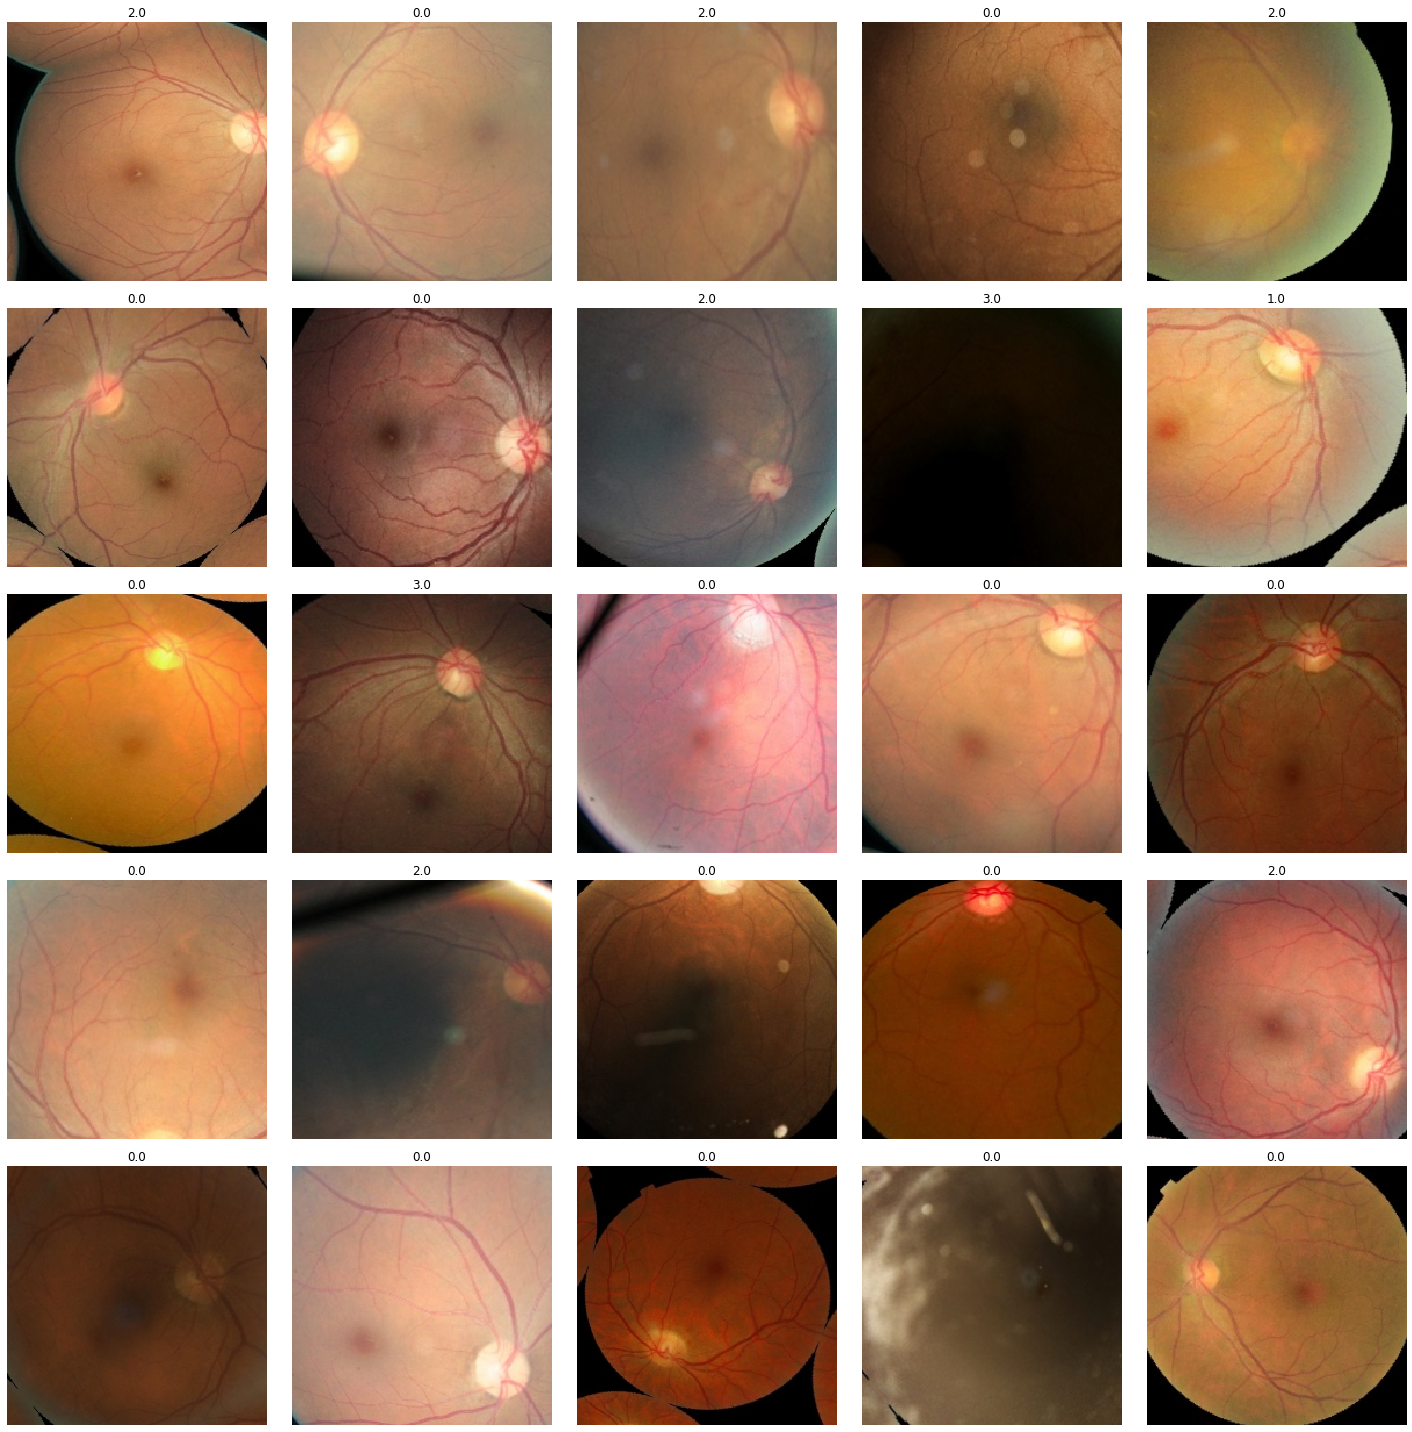

In [6]:
data.show_batch()

In [7]:
optar = partial(Ranger)
learn = Learner(data, md_ef, metrics = [quadratic_kappa], model_dir="models", bn_wd = False, true_wd = True, opt_func=optar)
learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.unfreeze()

In [8]:
lr = 1e-3

In [9]:
SUFFIX = 'UNFREEZE_P1'
learn.fit_one_cycle(20,
                    lr, 
                    wd=1e-2,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])

Better model found at epoch 0 with valid_loss value: 0.7709062695503235.
Better model found at epoch 1 with valid_loss value: 0.5517049431800842.
Better model found at epoch 2 with valid_loss value: 0.49029722809791565.
Better model found at epoch 3 with valid_loss value: 0.47540050745010376.
Better model found at epoch 4 with valid_loss value: 0.4470529556274414.
Better model found at epoch 5 with valid_loss value: 0.43822821974754333.
Better model found at epoch 6 with valid_loss value: 0.4264330565929413.
Better model found at epoch 7 with valid_loss value: 0.402393102645874.
Better model found at epoch 8 with valid_loss value: 0.39732882380485535.
Better model found at epoch 9 with valid_loss value: 0.3940322697162628.
Better model found at epoch 10 with valid_loss value: 0.39363253116607666.
Better model found at epoch 11 with valid_loss value: 0.3734545111656189.
Better model found at epoch 14 with valid_loss value: 0.3642202913761139.
Better model found at epoch 15 with valid_lo

In [10]:
BS = 64
SZ = 380

EXP_NAME = f'NB_EXP_765_CV_{FOLD}_{SZ}'
PATH = Path('../')
OLD_TRAIN = PATH/'old_train.csv'
OLD_TEST  = PATH/'old_test.csv'
TRAIN     = PATH/'train.csv'
IMG_OLD_TRAIN_224 = PATH/'old_train_images_512_crop'
IMG_OLD_TEST_224  = PATH/'old_test_images_512_crop'
IMG_TRAIN_224     = PATH/'train_images_512_crop'

In [11]:
df = get_all_data()
val_idx = strt_split(df['image'], df['labels'])[FOLD]

tfms = get_transforms(do_flip=True, 
                      flip_vert=True,
                      max_rotate=360,
                      max_zoom=False, 
                      max_lighting=0.1,
                      p_lighting=0.5,
                      xtra_tfms=zoom_crop(scale=(1.01, 1.35), do_rand=True))


data = ( ImageList.from_df(df=df, path='', cols='image')
        .split_by_idxs(valid_idx=val_idx[0], train_idx=val_idx[1])
        .label_from_df(cols='labels', label_cls=FloatList)
        .transform(tfms,size=SZ) #Data augmentation
        .databunch(bs=BS)
        .normalize(imagenet_stats)     
       )

(3504, 2)


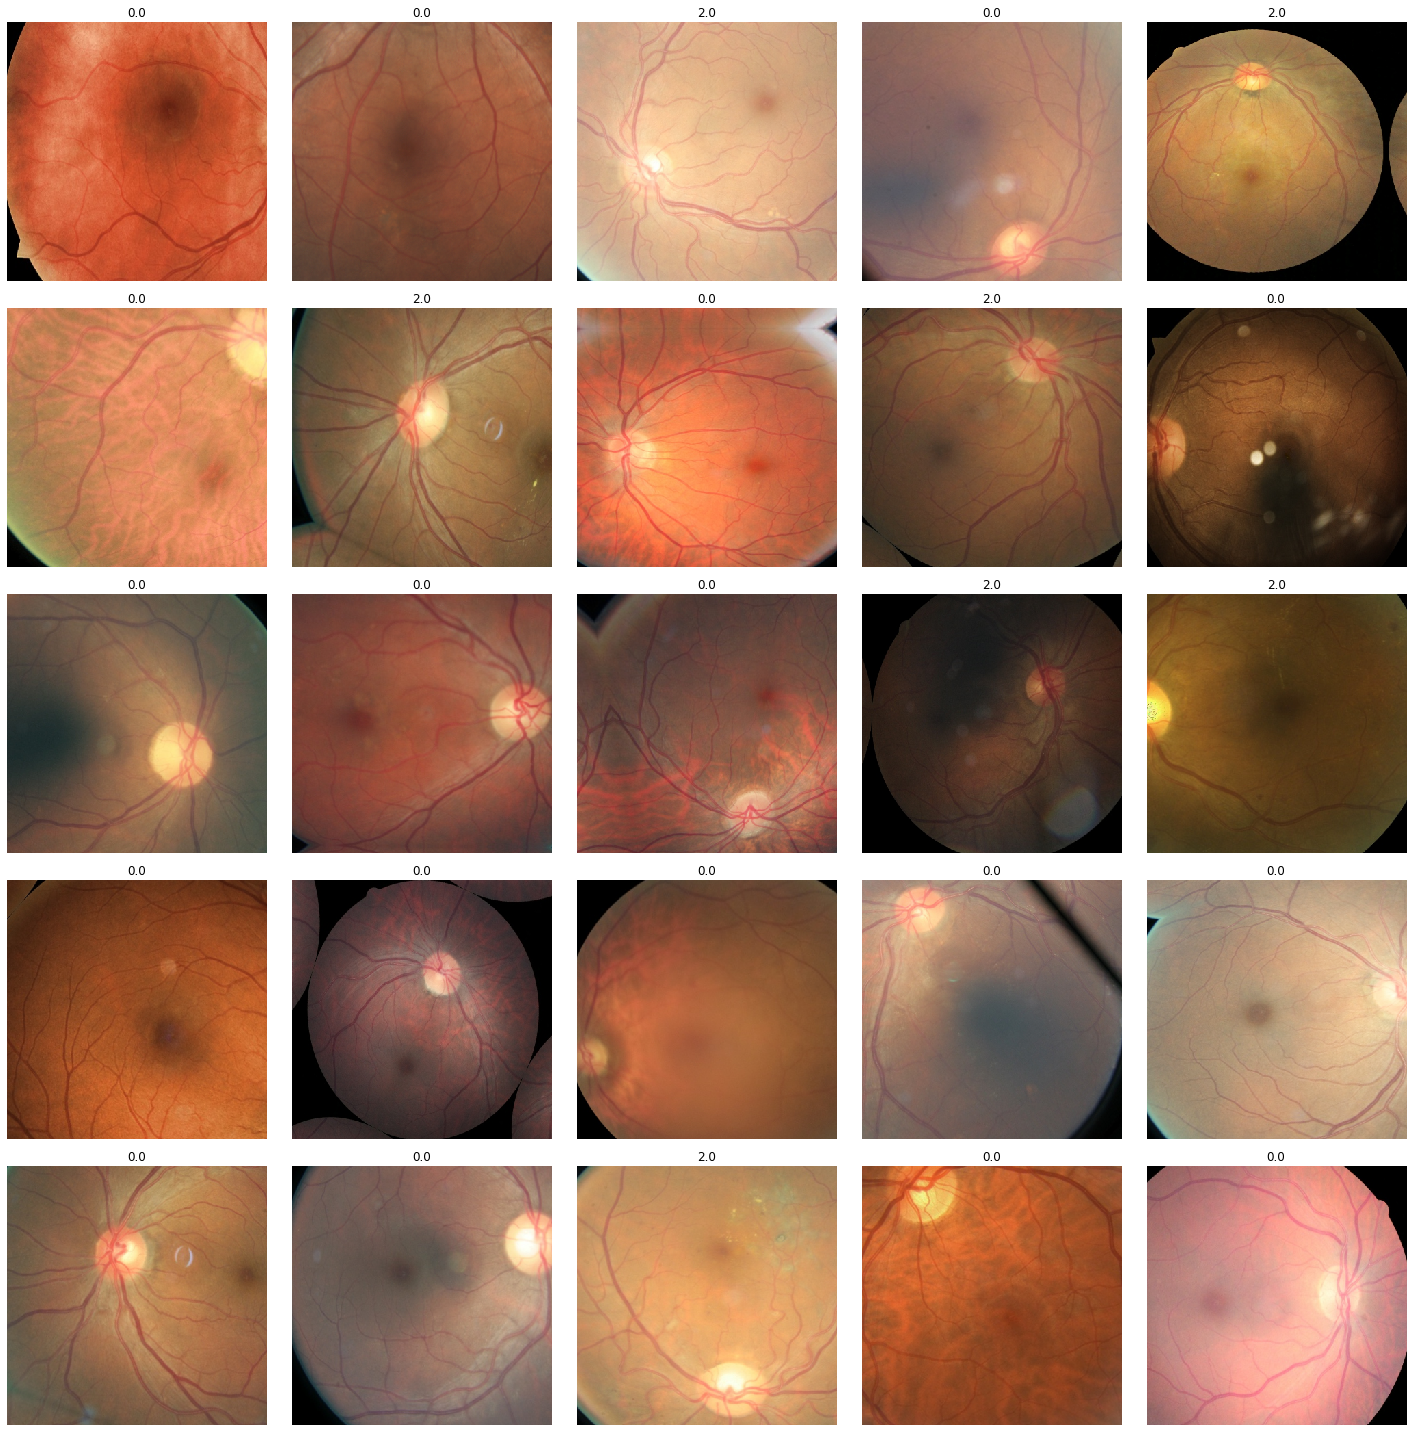

In [12]:
data.show_batch()

In [13]:
optar = partial(Ranger)
learn = Learner(data, md_ef, metrics = [quadratic_kappa], model_dir="models", bn_wd = False, true_wd = True, opt_func=optar)
learn.model = nn.DataParallel(learn.model)
learn.load(f'NB_EXP_765_CV_{FOLD}_UNFREEZE_P1')
learn.to_fp16()
learn.unfreeze()

set state called


In [14]:
lr = 1e-3

In [15]:
SUFFIX = 'UNFREEZE_P1'
learn.fit_one_cycle(8,
                    lr, 
                    wd=1e-2,
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])

Better model found at epoch 0 with valid_loss value: 0.27668333053588867.
Better model found at epoch 4 with valid_loss value: 0.27506983280181885.
Better model found at epoch 5 with valid_loss value: 0.26433396339416504.
Better model found at epoch 6 with valid_loss value: 0.25855082273483276.
Better model found at epoch 7 with valid_loss value: 0.2567961812019348.
set state called


In [16]:
!sudo shutdown

Shutdown scheduled for Mon 2019-08-26 16:11:05 UTC, use 'shutdown -c' to cancel.


#### 